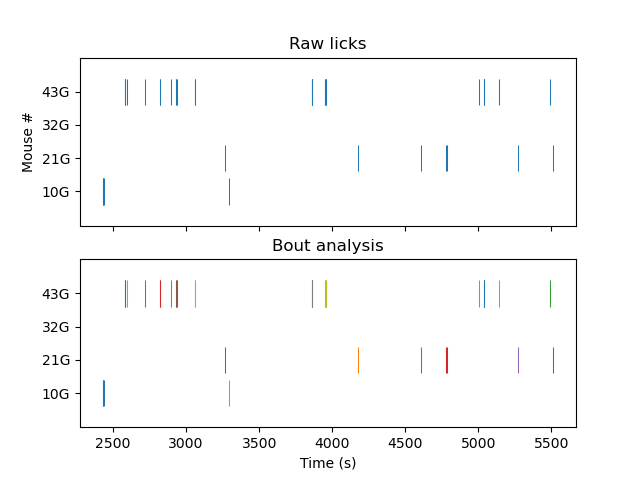

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from pntools import sampled
import beyelerlab as ab

%matplotlib widget

# fdir = r'C:\Users\prane\Downloads\PhotoM groupe 1'
fdir = r'C:\Users\prane\Downloads\Compulsive1G1'
# fdir = r'C:\Users\prane\Downloads\BingeB1'

default_params = {
    'file_types'        : ('lick_times', 'isos', 'GCaMP'), # add RCaMP (or similar) at the end if you have that
    'use_names_from'    : 'GCaMP', # source file for using mouse names
    'col_selector'      : 'Mouse', # I manually renamed your isos file to be consistent with columns in the GCaMP file
    'mouse_col_offset'  : 11,
    'bout_th'           : 10, # s
    'target_sr'         : 30, # Hz
    'discard_initial_s' : 15, # seconds
    'detrend_lambda'    : 1e6,
    'f_bandpass'        : (0.2, 6),
}
mouse_id = 'Mouse10G'


d = ab.Dataset(fdir, **default_params)
p = d.params

_, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].eventplot([x() for x in d.lick_times.values()], linelengths=0.8)
ax[0].set_ylabel('Mouse #')
ax[0].set_title('Raw licks')

for m_count, this_licktimes in enumerate(d.lick_times.values()):
    bout_classes = this_licktimes.bout_classes()
    for bout_class in np.unique(bout_classes):
        ax[1].eventplot(np.asarray(this_licktimes())[bout_classes == bout_class], color=f'C{bout_class-1}', lineoffsets=m_count, linelengths=0.8)
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Bout analysis')

for this_ax in ax:
    this_ax.set_yticks((0, 1, 2, 3))
    this_ax.set_yticklabels([x.removeprefix('Mouse') for x in d.mouse_names])

Text(0.5, 1.0, 'Step 4: bandpass')

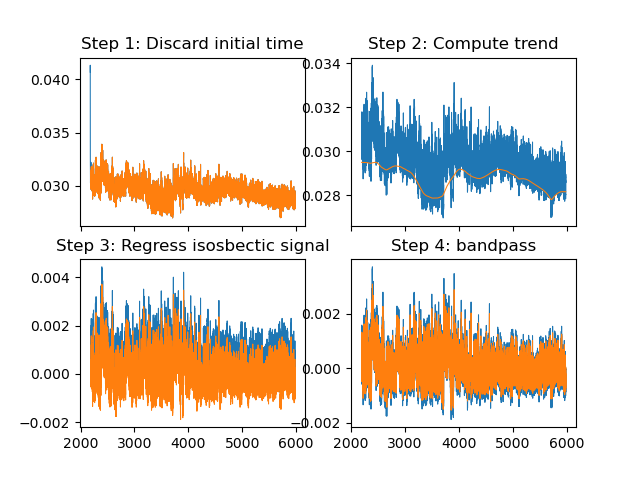

In [13]:
m = d(mouse_id).GCaMP
m_ref = d(mouse_id).isos[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)
m_proc = m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref).bandpass(*p.f_bandpass)
m_trend = m[m._t0 + p.discard_initial_s:].get_trend_airPLS(p.detrend_lambda) # F for df/F

_, ax = plt.subplots(2, 2, sharex=True)

ax[0, 0].plot(*m(''))
ax[0, 0].plot(*m[m._t0 + p.discard_initial_s:](''))
ax[0, 0].set_title('Step 1: Discard initial time')

ax[0, 1].plot(*m[m._t0 + p.discard_initial_s:](''))
ax[0, 1].plot(*m[m._t0 + p.discard_initial_s:].get_trend_airPLS(p.detrend_lambda)(''))
ax[0, 1].set_title('Step 2: Compute trend')

ax[1, 0].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda)(''))
ax[1, 0].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref)(''))
ax[1, 0].set_title('Step 3: Regress isosbectic signal')

ax[1, 1].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref)(''))
ax[1, 1].plot(*m[m._t0 + p.discard_initial_s:].detrend_airPLS(p.detrend_lambda).regress(m_ref).bandpass(*p.f_bandpass)(''))
ax[1, 1].set_title('Step 4: bandpass')

Text(0.5, 0, 'Time (s)')

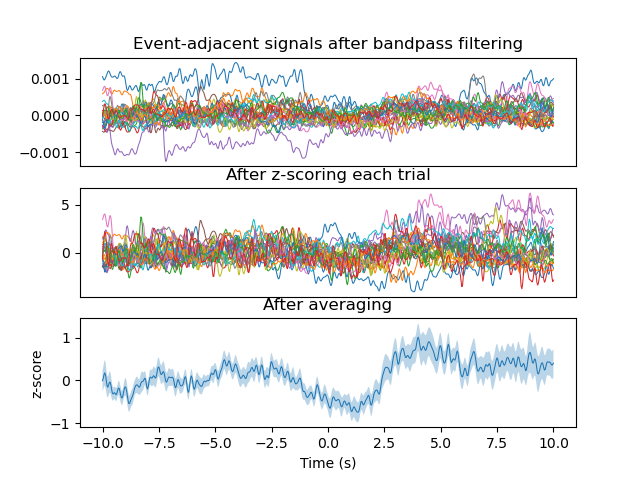

In [10]:
m_lickstart = d(mouse_id).lick_times
events = tuple(m_lickstart.bout_start())

discard_intervals = [(2050., 2075.), (3550., 3553.)] # add intervals in time that you wish to disregard for event related analysis
events_filtered = []
for ev_time in events:
    for dt_start, dt_end in discard_intervals:
        if dt_start <= ev_time <= dt_end:
            continue
        events_filtered.append(ev_time)
events = events_filtered

event_signals = sampled.Siglets(m_proc, events, window=(-10., 10.)) # set event window here (including baseline)
baseline_signals = sampled.Siglets(m_proc, events, window=(-10., 0.)) # set baseline window here
baseline_mean = baseline_signals(np.mean, axis='time')
baseline_std = baseline_signals(np.std, axis='time')
event_signals_z = (event_signals() - baseline_mean)/baseline_std

_, ax = plt.subplots(3, 1)
ax[0].plot(event_signals.t, event_signals()) # after bandpass
ax[0].set_title('Event-adjacent signals after bandpass filtering')
ax[0].get_xaxis().set_visible(False)
ax[1].plot(event_signals.t, event_signals_z) # z-scored signals
ax[1].get_xaxis().set_visible(False)
ax[1].set_title('After z-scoring each trial')

mu = np.mean(event_signals_z, axis=1)
sem = np.std(event_signals_z, axis=1)/np.sqrt(event_signals.n)
ax[2].plot(event_signals.t, mu) # mean of z-scored signals
ax[2].fill_between(event_signals.t, mu-sem, mu+sem, alpha=0.3) # standard error of the mean
ax[2].set_title('After averaging')
ax[2].set_ylabel('z-score')
ax[2].set_xlabel('Time (s)')


In [11]:
events

[2038.398528,
 3144.5928,
 3552.33824,
 4458.48912,
 4638.516224,
 4730.404032,
 5118.12256,
 5233.694048,
 5327.0888,
 5340.841568,
 5497.657888,
 5603.518656,
 7216.35536,
 7298.010304,
 7530.871264,
 7621.959392,
 7889.487296,
 8013.690624,
 8036.282208,
 8047.03024,
 8111.903424,
 8272.524352,
 8690.513184,
 8777.438976]

Text(0.5, 0, 'Time (s)')

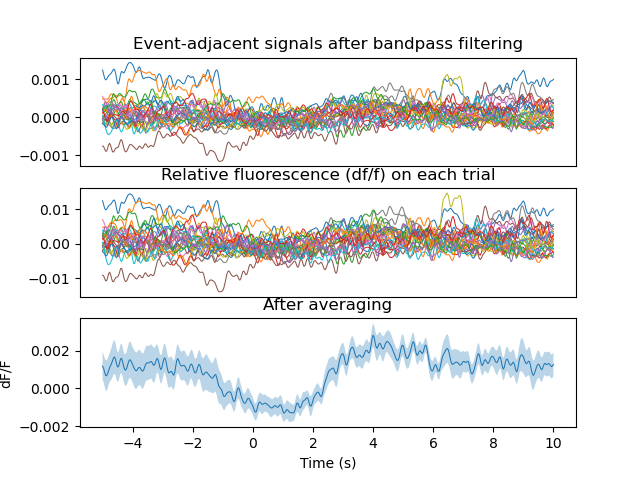

In [4]:
baseline_f = m_trend[events]
event_signals_dff = event_signals()/baseline_f # if you assume detrending is already an approximate df operation, then this can be considered df/f

_, ax = plt.subplots(3, 1)
ax[0].plot(event_signals.t, event_signals()) # after bandpass
ax[0].set_title('Event-adjacent signals after bandpass filtering')
ax[0].get_xaxis().set_visible(False)
ax[1].plot(event_signals.t, event_signals_dff) # z-scored signals
ax[1].get_xaxis().set_visible(False)
ax[1].set_title('Relative fluorescence (df/f) on each trial')

mu = np.mean(event_signals_dff, axis=1)
sem = np.std(event_signals_dff, axis=1)/np.sqrt(event_signals.n)
ax[2].plot(event_signals.t, mu) # mean of z-scored signals
ax[2].fill_between(event_signals.t, mu-sem, mu+sem, alpha=0.3) # standard error of the mean
ax[2].set_title('After averaging')
ax[2].set_ylabel('dF/F')
ax[2].set_xlabel('Time (s)')

In [9]:
import pandas as pd
import os

mu_z = np.mean(event_signals_z, axis=1)
mu_dff = np.mean(event_signals_dff, axis=1)
df = pd.DataFrame(np.asarray([mu_z, mu_dff]).T, index=event_signals.t, columns=['z_score', 'dff'])
df.to_csv(os.path.join(fdir, f'{mouse_id}_zscore_dff.csv'))